In [1]:
!rm -r AI2022MA
!git clone https://github.com/UmbertoJr/AI2022MA.git

Cloning into 'AI2022MA'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 213 (delta 103), reused 159 (delta 49), pack-reused 0
Receiving objects: 100% (213/213), 3.48 MiB | 7.92 MiB/s, done.
Resolving deltas: 100% (103/103), done.


name: d198
nPoints: 198
best_sol: 15780.0


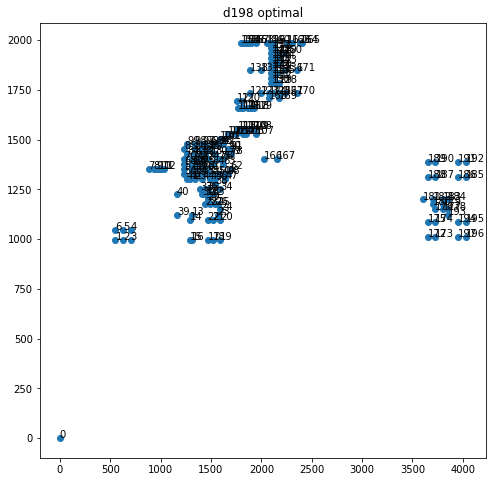

In [2]:
# from IO_manager.io_tsp import TSP_Instance_Creator
# if you are running not from your local add the prefix AI2022MA (comment the previous line and uncomment the following line)
from AI2022MA.IO_manager.io_tsp import TSP_Instance_Creator

ic = TSP_Instance_Creator("standard", 'd198.tsp') 
ic.print_info()
ic.plot_data()

name: pr439
nPoints: 439
best_sol: 107217.0


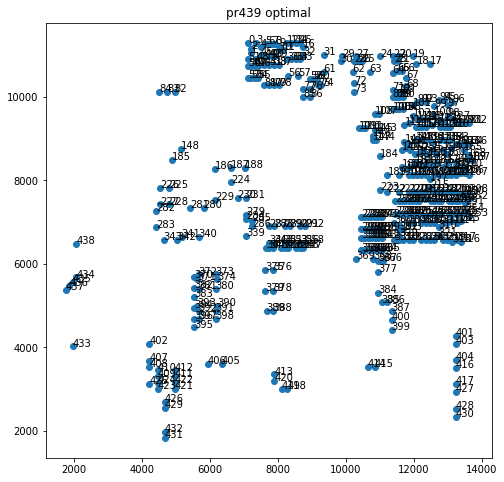

In [3]:
ic1 = TSP_Instance_Creator("standard", 'pr439.tsp') 
ic1.print_info()
ic1.plot_data()

name: u1060
nPoints: 1060
best_sol: 224094.0


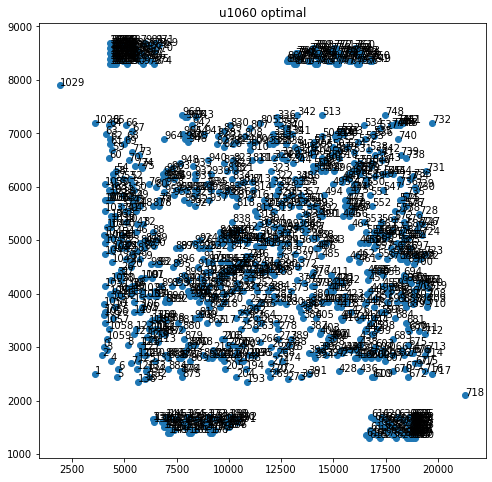

In [4]:
ic2 = TSP_Instance_Creator("standard", 'u1060.tsp') 
ic2.print_info()
ic2.plot_data()

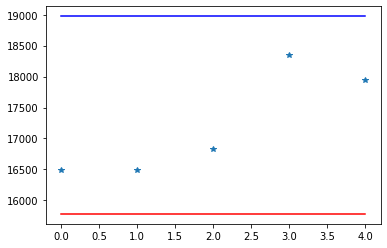

best gap with NN 20.25% on 1 trial,
with a total time of 0.006 seconds

best gap with random + 2opt 4.45% on 5 trials,
with a total time of 2.54 seconds


In [5]:
import numpy as np
from time import time as t
import matplotlib.pyplot as plt

# from solvers.local_search import TwoOpt
# from solvers.TSP_solver import Solver_TSP
# from solvers.constructive_algorithms import Random_Initializer, Nearest_Neighbor
# if you are not running from your local, add the prefix AI2021MA (comment the previous 3 lines and use instead the following 3 lines)
from AI2022MA.solvers.local_search import TwoOpt
from AI2022MA.solvers.TSP_solver import Solver_TSP
from AI2022MA.solvers.constructive_algorithms import Random_Initializer, Nearest_Neighbor

def naive_heuristic(solution, cost_sol, dist_matrix):
  for data in TwoOpt.local_search(solution, cost_sol, dist_matrix): 
    new_solution, new_cost, number_calls_ls, ending_cond = data
    yield  new_solution, new_cost, number_calls_ls, ending_cond

number_of_trials = 5
found_lens = []
start = t()
solver = Solver_TSP(('random', Random_Initializer.random_method))
solver.bind(('naive heuristic', naive_heuristic ))

for _ in range(number_of_trials):
  solver(ic)
  found_lens.append(solver.found_length)
end = t()

solver = Solver_TSP(('nearest neighbor', Nearest_Neighbor.nn))
solver(ic)

plt.plot(found_lens, "*")
plt.plot(np.ones(number_of_trials)*ic.best_sol, "r-")
plt.plot(np.ones(number_of_trials)*solver.found_length, "b-")
plt.show()
print(f"best gap with NN {solver.gap}% on 1 trial,\nwith a total time of {np.round(solver.time_to_solve, 5)} seconds")
print()
print(f"best gap with random + 2opt {np.round(100*(min(found_lens) - ic.best_sol)/ic.best_sol, 2)}% on {number_of_trials} trials,\nwith a total time of {np.round(end - start, 2)} seconds")

Next, I implement the Double Bridge here. Double Bridge is the exploitation part of the algorithm. In exploration we search the unexplored area of the feasible region. This is done by forming a pertubed solution which is done by passing the previous solution, the actual cost and the distance matrix to the method (perturb solution) of DoubleBridge class. Then I form 4 arbitrary cuts in the solution by keeping atleast a distance of 1 node between 2 cuts. Then I create 4 different segments using the cuts. These segments are defined by a, b, c, d. Now, I calculate the cost different between the solution [a, b, c, d] and the pertubed solution [a, c, b, d] using the difference_cost method. Then the perturbed solution is constructed and the actual cost is calculated using the cost difference and the previous cost.

In [6]:
class DoubleBridge:
  @staticmethod
  def difference_cost(solution, a, b, c, d, matrix):
    #cost difference
    cost_difference = matrix[a[len(a)-1], b[0]]+matrix[b[len(b)-1], c[0]]+matrix[c[len(c)-1], d[0]]+matrix[d[len(d)-1], a[0]]-matrix[a[len(a)-1], d[0]]-matrix[b[len(b)-1], a[0]]-matrix[c[len(c)-1], b[0]]-matrix[d[len(d)-1], c[0]]
    return cost_difference

  @staticmethod
  def perturb_solution(solution, actual_cost, matrix):
    #randomly selecting cut values
    cut_1, cut_2, cut_3, cut_4 = sorted(np.random.choice(case_solution[::2], 4, replace=False))
    #getting 4 segmented lists
    a, b, c, d = solution[cut_1+1:cut_2+1], solution[cut_2+1:cut_3+1], solution[cut_3+1:cut_4+1], np.concatenate([solution[cut_4+1:], solution[:cut_1+1]])
    #calculating cost difference using above method
    cost_difference = DoubleBridge.difference_cost(solution, a, b, c, d, matrix)
    #pertubed solution
    solution = np.concatenate([a, d, c, b])
    #updating the cost
    actual_cost = actual_cost-cost_difference
    return solution, actual_cost

In [7]:
# from solvers.constructive_algorithms import compute_length
# if you are not running from your local, add the prefix AI2022MA (comment the previous line and uncomment the following line)
from AI2022MA.solvers.constructive_algorithms import compute_length

# example perturbation
case_solution = np.arange(12)
matrix = np.random.rand(12, 12)
cost = compute_length(case_solution, matrix)
print(case_solution, cost)
print(matrix)


[ 0  1  2  3  4  5  6  7  8  9 10 11] 8.717801962733297
[[0.93145875 0.8386266  0.09826867 0.13616804 0.45453749 0.34078152
  0.24942024 0.35724469 0.48010575 0.56646246 0.5044625  0.70369052]
 [0.36348831 0.09737243 0.93786195 0.35908304 0.12981317 0.24686569
  0.4597516  0.60698712 0.46671514 0.21887233 0.9303034  0.80879848]
 [0.24767345 0.87050783 0.0860585  0.75898116 0.71441428 0.85213651
  0.02205307 0.10527752 0.36249898 0.08977264 0.15125616 0.67848483]
 [0.23588363 0.31884214 0.16508582 0.71897223 0.09868381 0.2962278
  0.75997849 0.98430559 0.30439503 0.78821018 0.64134315 0.63595254]
 [0.36421054 0.51065362 0.79092778 0.54659694 0.21226652 0.97680908
  0.25119225 0.67735261 0.4221439  0.81913264 0.17869909 0.69025868]
 [0.24189888 0.16620445 0.34786669 0.03427036 0.46083399 0.75018386
  0.14305363 0.83601369 0.8067797  0.10148683 0.6734521  0.65266888]
 [0.98513898 0.55536121 0.90066665 0.61104592 0.22793161 0.99718101
  0.64687233 0.88518265 0.94185257 0.62079616 0.7649849

In [8]:
new_sol, new_length = DoubleBridge.perturb_solution(case_solution, cost, matrix)
print(new_sol, new_length)

[ 1  2  3  4  9 10 11  0  7  8  5  6] 7.926786016586794


In [9]:
compute_length(new_sol, matrix)

7.926786016586795

In [10]:
import random

Next, I implement the acceptance criterion. The first one is the Better acceptance method. It is implemented by first creating the list of the previous solutions I got after implemeting the Double Bridge and also the initial solution. This list act as a memory as the next time I encounter the similar solution I don't have to call the iterative local search for reaching the minimum solution. Then I implement the selection crieterion for the Better criterion, in which I accept the new solution only if the cost of the new solution is less that the previous solution I got by calling previous local search and also if the new solution is not present in the memory list created above.\
Second, I implement the Random Walk criterion. I initially create the memory list like I did earlier in Better criterion. In random walk instead of selecting the new solution if it has the lower cost, we select the new solution anyway if the new solution is not present in the memory list.\
Third, I implement the LSMC by creating the memory list like the previous methods. Then I initiate the temperature. Then I implement the acceptance criterion by selecting the new solution if it has the lower cost then the previous best solution or else, we accept the new solution with the acceptance probability if it is not in the memory list. Then I reduce the temperature by a factor of 0.95.

In [11]:
# from solvers.local_search import TwoOpt
# from solvers.two_opt_with_candidate import twoOpt_with_cl
# if you are not running from your local, add the prefix AI2022MA (comment the previous lines and uncomment the following lines)
from AI2022MA.solvers.local_search import TwoOpt
from AI2022MA.solvers.two_opt_with_candidate import twoOpt_with_cl

cost_sol_better = []
cost_sol_RW = []
cost_sol_LSMC = []

def my_local_search(solution, cost_sol, dist_matrix):
  new_solution, new_cost = solution, cost_sol
  for data in TwoOpt.local_search(solution, cost_sol, dist_matrix): 
    new_solution, new_cost, number_calls_ls, ending_cond = data
  return new_solution, new_cost

def generate_cl(dist_matrix):
  n = dist_matrix.shape[0]
  cl = np.zeros((n, 20))
  for i in range(n):
    cl[i] = np.argsort(dist_matrix[i, :])[1: 21]
  return cl

class ILS_Better:
  @staticmethod
  def solve(solution, actual_cost, matrix):
    global cost_sol_better
    # list to store the history of the exploration i.e. the results of applying double bridge during better search to prevent doing local search if we get the previously found permutation by the double bridge
    history_of_exploration_better = []
    history_of_exploration_better.append((solution).tolist())
    new_sol, new_cost = my_local_search(solution, actual_cost, matrix)

    """
    #  in case you want to use twoOpt_with_cl
    cl = generate_cl(matrix) # remember you don't need to compute the cl each time
    new_sol, new_cost = twoOpt_with_cl(solution, actual_cost, matrix, cl)
    """
    best_sol,best_cost = new_sol, new_cost
    cost_sol_better.append(new_cost)
    ls_calls = 1
    while True:
      # implement perturbation  
      new_sol, new_cost = DoubleBridge.perturb_solution(best_sol, best_cost, matrix)
      if new_sol.tolist() not in history_of_exploration_better:
        history_of_exploration_better.append((new_sol).tolist())
        new_sol, new_cost = my_local_search(new_sol, new_cost, matrix)
        ls_calls = ls_calls + 1
        cost_sol_better.append(new_cost)
      # implement acceptance criterion
      # if the new cost obtained is less we accept the corresponding solution as the best solution, else we continue with the previous best solution
        if best_cost > new_cost:
          best_sol = new_sol
          best_cost = new_cost
      yield best_sol, best_cost, ls_calls, False

class ILS_RW:
  @staticmethod
  def solve(solution, actual_cost, matrix):
    global cost_sol_RW
    # list to store the history of the exploration i.e. the results of applying double bridge during random walk search to prevent doing local search if we get the previously found permutation by the double bridge
    history_of_exploration_RW = []
    history_of_exploration_RW.append((solution).tolist())
    new_sol, new_cost = my_local_search(solution, actual_cost, matrix)
    best_sol,best_cost = new_sol, new_cost
    cost_sol_RW.append(new_cost)
    ls_calls = 1
    while True:
      # implement perturbation  
      new_sol, new_cost = DoubleBridge.perturb_solution(best_sol, best_cost, matrix)
      if new_sol.tolist() not in history_of_exploration_RW:
        history_of_exploration_RW.append((new_sol).tolist())
        new_sol, new_cost = my_local_search(new_sol, new_cost, matrix)
        ls_calls = ls_calls + 1
        cost_sol_RW.append(new_cost)
      # implement acceptance criterion
      # we accept the new solution anyway
        best_sol = new_sol
        best_cost = new_cost
      yield best_sol, best_cost, ls_calls, False

class ILS_LSMC:
  @staticmethod
  def acceptance_criterion(best_cost, new_cost, temperature):
    # if the new cost is low we accept the new solution as the best solution
    if best_cost > new_cost:
      return new_cost
    # else we accept the new solution with the acceptance probability
    else:
      acceptance_probability = np.exp((best_cost-new_cost)/temperature)
      return random.choices([new_cost, best_cost], weights=[acceptance_probability, 1-acceptance_probability], k=1)
  @staticmethod
  def solve(solution, actual_cost, matrix):
    global cost_sol_LSMC
    # list to store the history of the exploration i.e. the results of applying double bridge during stimulated annealing search to prevent doing local search if we get the previously found permutation by the double bridge
    history_of_exploration_LSMC = []
    history_of_exploration_LSMC.append((solution).tolist())
    new_sol, new_cost = my_local_search(solution, actual_cost, matrix)
    best_sol,best_cost = new_sol, new_cost
    cost_sol_LSMC.append(new_cost)
    ls_calls = 1
    while True:
      # implement perturbation
      new_sol, new_cost = DoubleBridge.perturb_solution(best_sol, best_cost, matrix)
      if new_sol.tolist() not in history_of_exploration_LSMC:
        history_of_exploration_LSMC.append((new_sol).tolist())
        new_sol, new_cost = my_local_search(new_sol, new_cost, matrix)
        if ls_calls == 1:
          #initialing the temperature during the first call
          temp = 50
        ls_calls = ls_calls + 1
        cost_sol_LSMC.append(new_cost)
      # implement acceptance criterion
        cost = ILS_LSMC.acceptance_criterion(best_cost, new_cost, temp)
        if cost == new_cost:
          best_sol = new_sol
          best_cost = new_cost
        temp = temp*0.95
      yield best_sol, best_cost, ls_calls, False

In [12]:
import pandas as pd

seeds= [0, 123, 333]
time_to_solve = 180 # in seconds

names_instances = ["d198.tsp", "pr439.tsp", "u1060.tsp"]
samples = {name:{} for name in names_instances}
collectors = [cost_sol_better, cost_sol_RW, cost_sol_LSMC]
initializers = ["random"] 
init_functions = [Random_Initializer.random_method]
improvements = ["ILS-better","ILS-RW","ILS-LSMC"]
improve_functions = [ILS_Better.solve, ILS_RW.solve, ILS_LSMC.solve]
results = []
index = []
for s_ in seeds:
  for i, init in enumerate(initializers):
    for j, improve in enumerate(improvements):
      solver = Solver_TSP((init, init_functions[i]), seed_=s_, stop_run_after=time_to_solve)
      solver.bind((improve, improve_functions[j]))
      for name in names_instances:
        instance = TSP_Instance_Creator("standard", name)
        solver(instance)
        index.append((name, instance.best_sol, solver.name_method, s_))
        results.append([solver.found_length, solver.gap, solver.time_to_solve, solver.ls_calls])
        samples[name][improve] = np.round(np.abs(np.array(collectors[j]) - instance.best_sol)/instance.best_sol * 100, 2) 
        if j == 0:
          cost_sol_better = []
        elif j == 1:
          cost_sol_RW = []
        else:
          cost_sol_LSMC = []

index = pd.MultiIndex.from_tuples(index, names=['problem','optimal length', 'method', 'seed'])

pd.DataFrame(results, index=index, columns=["tour length", "gap", "time to solve", "calls Local Search"])

,,,,tour length,gap,time to solve,calls Local Search
problem,optimal length,method,seed,,,,
d198.tsp,15780.0,"initialized with random, improved with ILS-better",0,16681.0,5.71,180.000,23
pr439.tsp,107217.0,"initialized with random, improved with ILS-better",0,118261.0,10.30,180.000,17
u1060.tsp,224094.0,"initialized with random, improved with ILS-better",0,247671.0,10.52,180.001,32
d198.tsp,15780.0,"initialized with random, improved with ILS-RW",0,16505.0,4.59,180.094,1394
pr439.tsp,107217.0,"initialized with random, improved with ILS-RW",0,113985.0,6.31,180.129,262
u1060.tsp,224094.0,"initialized with random, improved with ILS-RW",0,254104.0,13.39,180.702,39
d198.tsp,15780.0,"initialized with random, improved with ILS-LSMC",0,16546.0,4.85,180.000,57
pr439.tsp,107217.0,"initialized with random, improved with ILS-LSMC",0,111782.0,4.26,180.000,101
u1060.tsp,224094.0,"initialized with random, improved with ILS-LSMC",0,252206.0,12.54,181.985,43


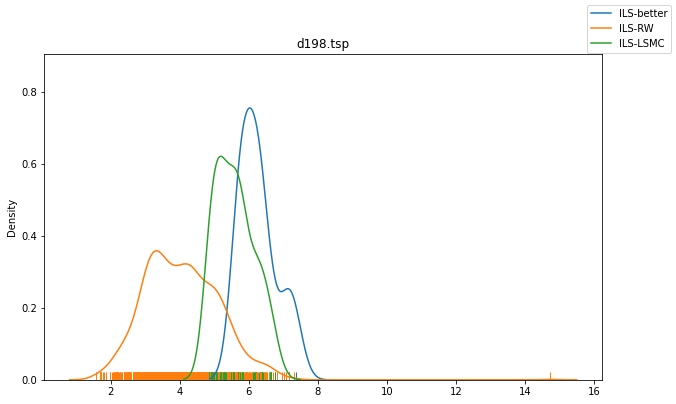

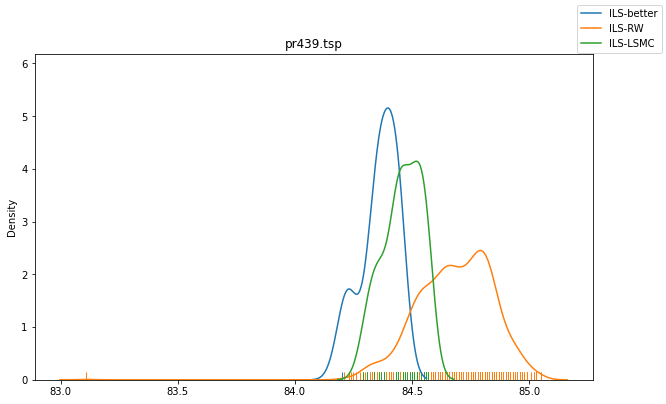

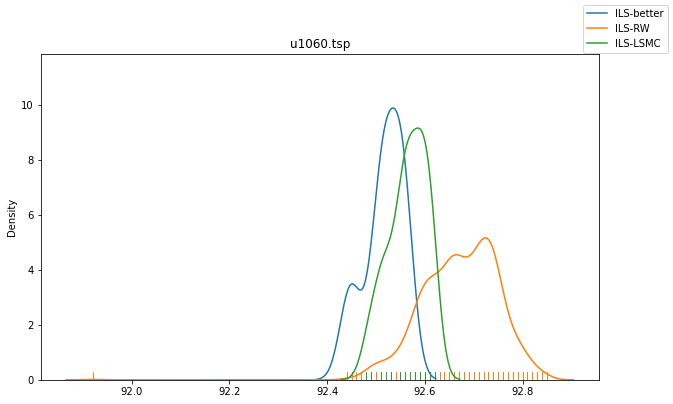

In [13]:
import warnings
import seaborn as sns

with warnings.catch_warnings():
  warnings.simplefilter("ignore")    
  for instance in names_instances:
    fig = plt.figure(figsize=(10,6))
    for j, improve in enumerate(improvements):
      sns.distplot(samples[instance][improve], rug=True, hist=False)
    
    fig.legend(labels=improvements)
    plt.title(instance)
    plt.show()

**Results**: The above table and graphs represent the results. We can observe from the table that minimum gap for the d198 problem is 0.75 which is achieved by LSMC acceptance criterion. The minimum gap achived for the p439 problem is 4.26 which is also achived by LSMC acceptance criterion. While for the minimum gap for u1060 problem is 10.52 which is achieved by Better acceptance criterion.